In [1]:
# basics libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import time

# deep learning libraries
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.models import Sequential,load_model,Model
from keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPool2D,ZeroPadding2D,Activation
from keras.layers import Conv2D,MaxPool2D,Dense,Dropout,BatchNormalization,Flatten,Input

# magic functions
%matplotlib inline

2022-04-21 14:23:49.492764: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-21 14:23:49.493421: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# images full path
fits_full_path = './simulations/fits_files/'

# selected bandpasses
selected_bandpass = {
    'desg':'g',
    'desr':'r',
    'desi':'i'
}

# metadata files
metadata = pd.read_csv(fits_full_path+'metadata.txt')
metadata.dropna(inplace=True) # first line has Nan values and I still don't know why

# basic variables
num_pix = metadata['numPix-g'].iloc[-1] # same for all bandpasses
pixel_scale = metadata['pixel_scale-g'].iloc[-1] # same for all bandpasses
system_label = np.linspace(0, 4999, 5000, dtype=int)

In [3]:
metadata.head()

,OBJID-g,H0-g,Om0-g,exposure_time-g,numPix-g,pixel_scale-g,psf_type-g,read_noise-g,ccd_gain-g,seeing-g,...,PLANE_1-REDSHIFT-g,PLANE_2-REDSHIFT-g,PLANE_1-REDSHIFT-r,PLANE_2-REDSHIFT-r,PLANE_1-REDSHIFT-i,PLANE_2-REDSHIFT-i,PLANE_1-REDSHIFT-z,PLANE_2-REDSHIFT-z,PLANE_1-REDSHIFT-Y,PLANE_2-REDSHIFT-Y
0,1,73.0,0.3,90.0,100,0.263,GAUSSIAN,7,6.083,1.440,...,0.628972,3.070253,0.628972,3.070253,0.628972,3.070253,0.628972,3.070253,0.628972,3.070253
1,2,73.0,0.3,90.0,100,0.263,GAUSSIAN,7,6.083,1.181,...,0.880797,4.451502,0.880797,4.451502,0.880797,4.451502,0.880797,4.451502,0.880797,4.451502
2,3,73.0,0.3,90.0,100,0.263,GAUSSIAN,7,6.083,1.122,...,0.323899,1.624318,0.323899,1.624318,0.323899,1.624318,0.323899,1.624318,0.323899,1.624318
3,4,73.0,0.3,90.0,100,0.263,GAUSSIAN,7,6.083,1.101,...,0.640998,3.990177,0.640998,3.990177,0.640998,3.990177,0.640998,3.990177,0.640998,3.990177
4,5,73.0,0.3,90.0,100,0.263,GAUSSIAN,7,6.083,1.261,...,0.875360,5.700878,0.875360,5.700878,0.875360,5.700878,0.875360,5.700878,0.875360,5.700878


In [4]:
# split our data in training and test dataset with ration 80 - 20 %
np.random.seed(42)
files_names_train, files_names_test = train_test_split(system_label, test_size=0.2)
print(len(files_names_train), len(files_names_test))

4000 1000


In [5]:
# split our data in training and validation dataset with ration 90 - 10 %
np.random.seed(42)
files_names_train, files_names_val = train_test_split(files_names_train, test_size=0.1)
print(len(files_names_train), len(files_names_val), len(files_names_test))

3600 400 1000


In [6]:
# train dataset
x_train = []
y_train = []
for i in range(0, len(files_names_train)):
    x_train.append(np.array([fits.open(fits_full_path + selected_bandpass['desg'] + '/' +  str(files_names_train[i])+'.fits')[0].data, fits.open(fits_full_path + selected_bandpass['desr'] + '/' +  str(files_names_train[i])+'.fits')[0].data, fits.open(fits_full_path + selected_bandpass['desi'] + '/' +  str(files_names_train[i])+'.fits')[0].data]))
    
x_train = np.array(x_train)
y_train = np.array([np.array(metadata['PLANE_2-OBJECT_1-LIGHT_PROFILE_1-n_sersic-g'][files_names_train]), np.array(metadata['PLANE_2-OBJECT_1-LIGHT_PROFILE_1-R_sersic-g'][files_names_train]), np.array(metadata['PLANE_1-OBJECT_1-MASS_PROFILE_1-theta_E-g'][files_names_train])]).T


# validation dataset
x_val = []
y_val = []
for i in range(0, len(files_names_val)):
    x_val.append(np.array([fits.open(fits_full_path + selected_bandpass['desg'] + '/' +  str(files_names_val[i])+'.fits')[0].data, fits.open(fits_full_path + selected_bandpass['desr'] + '/' +  str(files_names_val[i])+'.fits')[0].data, fits.open(fits_full_path + selected_bandpass['desi'] + '/' +  str(files_names_val[i])+'.fits')[0].data]))
    
x_val = np.array(x_val)
y_val = np.array([np.array(metadata['PLANE_2-OBJECT_1-LIGHT_PROFILE_1-n_sersic-g'][files_names_val]), np.array(metadata['PLANE_2-OBJECT_1-LIGHT_PROFILE_1-R_sersic-g'][files_names_val]), np.array(metadata['PLANE_1-OBJECT_1-MASS_PROFILE_1-theta_E-g'][files_names_val])]).T

# validation dataset
x_test = []
y_test = []
for i in range(0, len(files_names_test)):
    x_test.append(np.array([fits.open(fits_full_path + selected_bandpass['desg'] + '/' +  str(files_names_test[i])+'.fits')[0].data, fits.open(fits_full_path + selected_bandpass['desr'] + '/' +  str(files_names_test[i])+'.fits')[0].data, fits.open(fits_full_path + selected_bandpass['desi'] + '/' +  str(files_names_test[i])+'.fits')[0].data]))
    
x_test = np.array(x_test)
y_test = np.array([np.array(metadata['PLANE_2-OBJECT_1-LIGHT_PROFILE_1-n_sersic-g'][files_names_test]), np.array(metadata['PLANE_2-OBJECT_1-LIGHT_PROFILE_1-R_sersic-g'][files_names_test]), np.array(metadata['PLANE_1-OBJECT_1-MASS_PROFILE_1-theta_E-g'][files_names_test])]).T


In [7]:
#np.array(metadata['PLANE_1-OBJECT_1-MASS_PROFILE_1-theta_E-g'][files_names_test])

In [8]:
x_train = np.moveaxis(x_train, 1, 2)
x_train = np.moveaxis(x_train, 3, 2)

x_test = np.moveaxis(x_test, 1, 2)
x_test = np.moveaxis(x_test, 3, 2)

x_val = np.moveaxis(x_val, 1, 2)
x_val = np.moveaxis(x_val, 3, 2)

print(x_train.shape, x_test.shape, x_val.shape)

(3600, 100, 100, 3) (1000, 100, 100, 3) (400, 100, 100, 3)


In [9]:
# Our deep learning algorithm 
inputs = tf.keras.Input(shape=(100, 100, 3))

x = tf.keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu')(inputs)
x = tf.keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu')(x)
x = tf.keras.layers.Conv2D(filters=32, kernel_size=(1,1), activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(filters=32, kernel_size=(5,5), activation='relu')(x)
x = tf.keras.layers.Conv2D(filters=32, kernel_size=(5,5), activation='relu')(x)
x = tf.keras.layers.Conv2D(filters=32, kernel_size=(1,1), activation='relu')(x)
x = tf.keras.layers.Conv2D(filters=32, kernel_size=(5,5), activation='relu')(x)

x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
#x = tf.keras.layers.Dropout(rate=0.2)(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
#x = tf.keras.layers.Dropout(rate=0.2)(x)

outputs = tf.keras.layers.Dense(3, activation='linear')(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer = 'adam',
    loss = 'mse'
)

gen = tf.keras.preprocessing.image.ImageDataGenerator()

batch_size=32
start = time.perf_counter()
generator = gen.flow(x_train, y_train, batch_size = batch_size)

history = model.fit_generator(
    generator,
    steps_per_epoch=len(x_train)/batch_size,
    epochs=30,
    validation_data = (x_val, y_val),
    validation_steps = len(x_val),
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        )
    ]

)

2022-04-21 14:24:20.940161: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-04-21 14:24:20.947161: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-21 14:24:20.947617: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-04-21 14:24:20.947749: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-04-21 14:24:20.947836: W tensorflow/stream_executor/platform/default/dso_loader.cc:6

Epoch 1/30
112/112 [==============================] - 40s 334ms/step - loss: 6.9754 - val_loss: 1.2313
Epoch 2/30
112/112 [==============================] - 32s 289ms/step - loss: 1.3310 - val_loss: 1.2386
Epoch 3/30
112/112 [==============================] - 34s 299ms/step - loss: 1.2764 - val_loss: 1.0496
Epoch 4/30
112/112 [==============================] - 34s 302ms/step - loss: 1.1314 - val_loss: 0.9027
Epoch 5/30
112/112 [==============================] - 43s 378ms/step - loss: 1.0348 - val_loss: 0.8801
Epoch 6/30
112/112 [==============================] - 34s 306ms/step - loss: 0.9437 - val_loss: 0.7800
Epoch 7/30
112/112 [==============================] - 31s 279ms/step - loss: 0.8653 - val_loss: 0.7068
Epoch 8/30
112/112 [==============================] - 31s 276ms/step - loss: 0.7995 - val_loss: 0.7422
Epoch 9/30
112/112 [==============================] - 38s 340ms/step - loss: 0.7648 - val_loss: 0.7417
Epoch 10/30
112/112 [==============================] - 36s 319ms/step - l

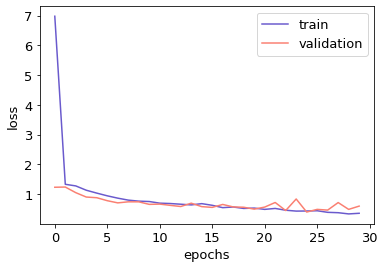

In [10]:
plt.rcParams.update({"font.size": 13})

plt.plot(history.history['loss'], label='train', c='slateblue')
plt.plot(history.history['val_loss'], label='validation', c='salmon')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend();

In [11]:
%%time
results = np.squeeze(model.predict(x_test)).T

2022-04-21 14:41:53.031263: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 120000000 exceeds 10% of free system memory.


CPU times: user 15.3 s, sys: 867 ms, total: 16.1 s
Wall time: 4.85 s


In [12]:
results = pd.DataFrame(np.array([files_names_test+1, results[0], y_test.T[0], results[1], y_test.T[1], results[2], y_test.T[2]]).T, columns=['sys', 'nsersic_pred', 'nsersic_true', 'rsersic_pred', 'rsersic_true', 'thetae_pred', 'thetae_true'])
results.head()

,sys,nsersic_pred,nsersic_true,rsersic_pred,rsersic_true,thetae_pred,thetae_true
0,1502.0,4.975446,5.208745,4.229552,3.799595,3.187257,3.219814
1,2587.0,3.962216,3.366610,4.127119,3.039736,3.327118,3.111357
2,2654.0,3.489871,3.910909,6.757718,7.021948,2.471777,2.374734
3,1056.0,3.856828,4.522376,6.394562,7.101421,5.528607,5.918189
4,706.0,4.092981,4.468102,6.196817,6.360108,3.179679,2.843355


In [13]:
# deep learning results to a txt
results.to_csv('./dl_results/DL_results.csv', index=False)

In [14]:
# save our model to a h5 file
model.save('./dl_results/dl_architecture.h5')

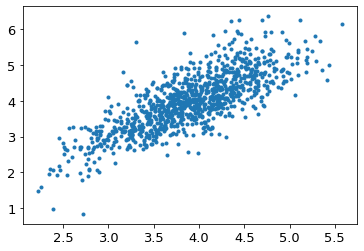

In [15]:
plt.plot(results['nsersic_pred'], results['nsersic_true'], '.')

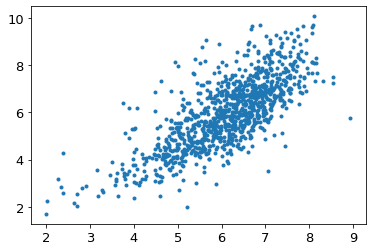

In [16]:
plt.plot(results['rsersic_pred'], results['rsersic_true'], '.')

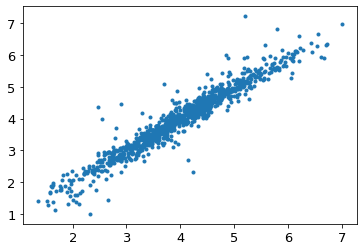

In [17]:
plt.plot(results['thetae_pred'], results['thetae_true'], '.')

In [18]:
model.save('./dl_results/my_dl_model')

2022-04-21 14:41:57.587890: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./dl_results/my_dl_model/assets


In [19]:
model.save_weights('./dl_results/weights')

In [30]:
metadata_test=metadata.iloc[files_names_test]
metadata_test.reset_index()

,index,OBJID-g,H0-g,Om0-g,exposure_time-g,numPix-g,pixel_scale-g,psf_type-g,read_noise-g,ccd_gain-g,...,PLANE_1-REDSHIFT-g,PLANE_2-REDSHIFT-g,PLANE_1-REDSHIFT-r,PLANE_2-REDSHIFT-r,PLANE_1-REDSHIFT-i,PLANE_2-REDSHIFT-i,PLANE_1-REDSHIFT-z,PLANE_2-REDSHIFT-z,PLANE_1-REDSHIFT-Y,PLANE_2-REDSHIFT-Y
0,1501,1502,73.0,0.3,90.0,100,0.263,GAUSSIAN,7,6.083,...,0.520542,1.401964,0.520542,1.401964,0.520542,1.401964,0.520542,1.401964,0.520542,1.401964
1,2586,2587,73.0,0.3,90.0,100,0.263,GAUSSIAN,7,6.083,...,0.432048,2.126668,0.432048,2.126668,0.432048,2.126668,0.432048,2.126668,0.432048,2.126668
2,2653,2654,73.0,0.3,90.0,100,0.263,GAUSSIAN,7,6.083,...,0.870553,3.289295,0.870553,3.289295,0.870553,3.289295,0.870553,3.289295,0.870553,3.289295
3,1055,1056,73.0,0.3,90.0,100,0.263,GAUSSIAN,7,6.083,...,0.856923,2.497602,0.856923,2.497602,0.856923,2.497602,0.856923,2.497602,0.856923,2.497602
4,705,706,73.0,0.3,90.0,100,0.263,GAUSSIAN,7,6.083,...,0.566559,3.057067,0.566559,3.057067,0.566559,3.057067,0.566559,3.057067,0.566559,3.057067
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,4711,4712,73.0,0.3,90.0,100,0.263,GAUSSIAN,7,6.083,...,0.397950,3.840747,0.397950,3.840747,0.397950,3.840747,0.397950,3.840747,0.397950,3.840747
996,2313,2314,73.0,0.3,90.0,100,0.263,GAUSSIAN,7,6.083,...,0.895501,5.232363,0.895501,5.232363,0.895501,5.232363,0.895501,5.232363,0.895501,5.232363
997,3214,3215,73.0,0.3,90.0,100,0.263,GAUSSIAN,7,6.083,...,0.380989,3.962468,0.380989,3.962468,0.380989,3.962468,0.380989,3.962468,0.380989,3.962468
998,2732,2733,73.0,0.3,90.0,100,0.263,GAUSSIAN,7,6.083,...,0.703460,3.040970,0.703460,3.040970,0.703460,3.040970,0.703460,3.040970,0.703460,3.040970


In [31]:
metadata_test.to_csv('./test_dataset.csv')